In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

from torchvision.datasets.mnist import MNIST, FashionMNIST
from torch.utils.data import DataLoader

import numpy as np

from tqdm import tqdm_notebook

import snip_resnet.masked_layers as layers

import matplotlib.pyplot as plt
%matplotlib inline

### Response visualizations

In [2]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(x.size(0), -1)

INPUT_SIZE = 28 * 28
class LeNet_300_100(nn.Module):
    def __init__(self):
        super(LeNet_300_100, self).__init__()
        self.flat = Flatten()
        self.fc1 = layers.MaskedLinear(INPUT_SIZE, 300)
        self.net = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.5),
            layers.MaskedLinear(300, 100),
            nn.ReLU(),
            nn.Dropout(0.5),
            layers.MaskedLinear(100, 10),
        )
        
    def forward(self, input):
        x = self.fc1(self.flat(input))
        return self.net(x)

In [3]:
def make_label_dataloader(name='mnist', label=None):
    if name == 'mnist':
        data = MNIST('./data/mnist',
                       download=True,
                       transform=transforms.Compose([
                       transforms.Resize((28, 28)),
                       transforms.ToTensor()]))
    else:
        data = FashionMNIST('./data/fasionmnist',
                           download=True,
                           transform=transforms.Compose([
                           transforms.Resize((28, 28)),
                           transforms.ToTensor()]))
    
    idx = (data.train_labels == label)
    data.train_data = data.train_data[idx]
    data.train_labels = data.train_labels[idx]
    label_loader = DataLoader(data, batch_size=100, shuffle=False)
    return label_loader

In [4]:
from itertools import product

def make_history(name):
    sparsity_levels = [0.6, 0.7, 0.8, 0.9, 0.95, 0.98]
    labels_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    history = dict()
    criterion = nn.CrossEntropyLoss()

    for (label, sparsity_level) in tqdm_notebook(product(labels_list, sparsity_levels)):
        net = LeNet_300_100().cuda()
        net.train()
        loader = make_label_dataloader(name, label)

        for input, target in loader:
            input, target = input.cuda(), target.cuda()
            output = net(input)
            loss = criterion(output, target)
            loss.backward()
            break

        agg_tensor = []
        for child in net.children():
            if isinstance(child, layers.MaskedConv2d) or isinstance(child, layers.MaskedLinear):
                agg_tensor += child.get_mask_grad()

        agg_tensor = torch.cat(agg_tensor, dim=0).cpu().numpy()
        value = np.percentile(agg_tensor, sparsity_level * 100)

        for child in net.children():
            if isinstance(child, layers.MaskedConv2d) or isinstance(child, layers.MaskedLinear):
                child.truncate_mask(value)

        history[(label, sparsity_level)] = net.fc1.mask_weight.mean(0)
        
    return history

In [5]:
history_mnist = make_history('mnist')
history_fasion = make_history('fashion')

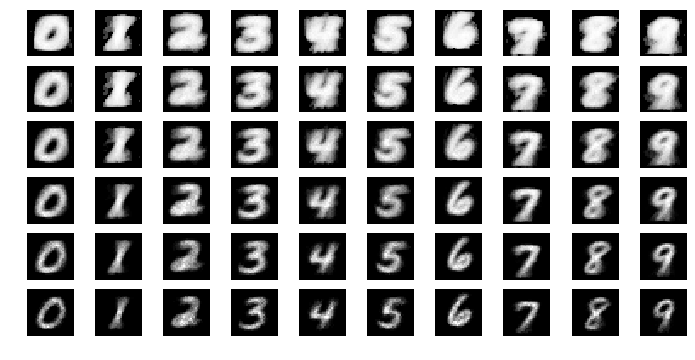

In [6]:
fig, ax = plt.subplots(6, 10, figsize=(12,6))
x_ = {0.6:0, 0.7:1, 0.8:2, 0.9:3, 0.95:4, 0.98:5}

for elem in history_mnist.keys():
    label, sparsity_level = elem
    w = history_mnist[elem]
    x, y = x_[sparsity_level], label
    ax[x][y].imshow(w.view(28,28).cpu().detach().numpy(), cmap='gray')
    ax[x][y].axis('off')
plt.show()

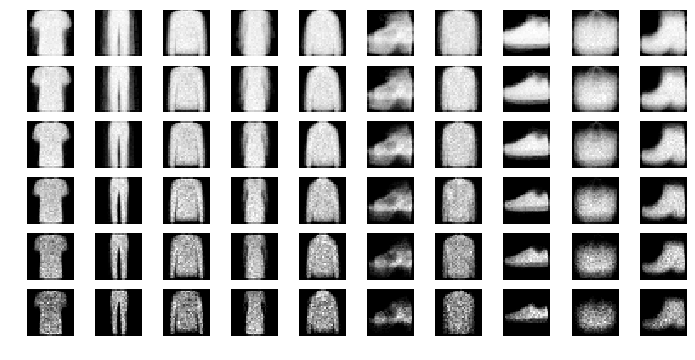

In [7]:
fig, ax = plt.subplots(6, 10, figsize=(12,6))
x_ = {0.6:0, 0.7:1, 0.8:2, 0.9:3, 0.95:4, 0.98:5}

for elem in history_fasion.keys():
    label, sparsity_level = elem
    w = history_fasion[elem]
    x, y = x_[sparsity_level], label
    ax[x][y].imshow(w.view(28,28).cpu().detach().numpy(), cmap='gray')
    ax[x][y].axis('off')
plt.show()

### Different levels of sparsity vs accuracy

In [18]:
grid = np.arange(0, 95, 15)

In [20]:
import numpy as np

import argparse
import os
import random
import time
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as torchmodels

from torch.optim.lr_scheduler import ReduceLROnPlateau

history = []
for sparse in grid:
    
    history_cur = []
    for sample in tqdm_notebook(range(5)):
        
        data_train = MNIST('./data/mnist',
                           download=True,
                           transform=transforms.Compose([
                               transforms.Resize((28, 28)),
                               transforms.ToTensor()]))
        data_test = MNIST('./data/mnist',
                          train=False,
                          download=True,
                          transform=transforms.Compose([
                              transforms.Resize((28, 28)),
                              transforms.ToTensor()]))
        data_train_loader = DataLoader(data_train, batch_size=256, shuffle=True)
        data_test_loader = DataLoader(data_test, batch_size=1024)

        criterion = nn.CrossEntropyLoss()
        net = LeNet_300_100()

        sampler = DataLoader(data_train, batch_size=100, shuffle=True)
        for x, y in sampler: break
        output = net(x)
        loss = criterion(output, y)
        loss.backward()

        #compute percentile
        agg_tensor = []
        for child in net.children():
            if isinstance(child, layers.MaskedLinear):
                agg_tensor += child.get_mask_grad()
        agg_tensor = torch.cat(agg_tensor, dim=0).numpy()
        value = np.percentile(agg_tensor, sparse)

        for child in net.children():
            if isinstance(child, layers.MaskedLinear):
                child.truncate_mask(value)

        optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), 
                              lr=1e-3)
        lr_scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', threshold=1e-3, 
                                         threshold_mode='abs', patience=3, factor=0.1, verbose=False)

        n_epoch = 30
        for epoch in tqdm_notebook(range(n_epoch)):
            loss_track = 0.

            net.train()
            for input, target in data_train_loader:

                optimizer.zero_grad()
                output = net(input)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                loss_track += loss.item()

            net.eval()
            with torch.no_grad():

                correct, test_loss = 0., 0.
                for input, target in data_test_loader:

                    output = net(input)
                    test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
                    pred = output.argmax(dim=1, keepdim=True)
                    correct += pred.eq(target.view_as(pred)).sum().item()

                test_loss /= len(data_test_loader.dataset)

                lr_scheduler.step(1. * correct / len(data_test_loader.dataset))

        history_cur += [100 - 100. * correct / len(data_test_loader.dataset)]
        
    history += [history_cur]

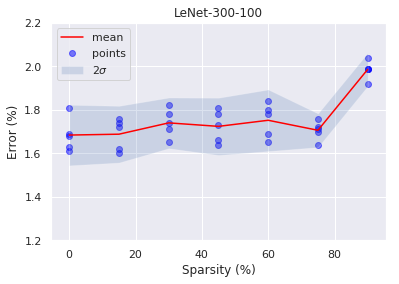

In [40]:
import seaborn as sns
sns.set(style="darkgrid")

mean = np.array([np.mean(history[i]) for i in range(len(history))])
std = np.array([np.std(history[i]) for i in range(len(history))])

plt.title('LeNet-300-100')
plt.plot(grid, mean, color='red', label='mean')
for i in range(len(history)):
    if i == 0:
        plt.scatter([grid[i]] * 5, history[i], color='blue', alpha=0.5, label='points')
    else:
        plt.scatter([grid[i]] * 5, history[i], color='blue', alpha=0.5)
plt.fill_between(grid, mean - 2*std, mean + 2*std, alpha=0.2, label=r'$2\sigma$')
plt.ylim(1.2, 2.2)
plt.xlabel('Sparsity (%)')
plt.ylabel('Error (%)')
plt.legend()
plt.show()